In [1]:
import math 
import random
import torch
import os
from d2l import torch as d2l 

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

数据取自ptb文件夹，数据来源于华尔街日报的文章

In [3]:
def read_ptb():
    """将PTB数据集加载到文本行的列表中"""
    data_dir = 'ptb'
    # Readthetrainingset.
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]

In [4]:
sentences = read_ptb()

In [5]:
type(sentences)

list

In [6]:
sentences[0]

['aer',
 'banknote',
 'berlitz',
 'calloway',
 'centrust',
 'cluett',
 'fromstein',
 'gitano',
 'guterman',
 'hydro-quebec',
 'ipo',
 'kia',
 'memotec',
 'mlx',
 'nahb',
 'punts',
 'rake',
 'regatta',
 'rubens',
 'sim',
 'snack-food',
 'ssangyong',
 'swapo',
 'wachter']

In [7]:
len(sentences)

42069

词表中出现次数小于十次的单词都会被'<unk>'替换

In [8]:
vocab = d2l.Vocab(sentences, min_freq=10)
f'vocab size: {len(vocab)}'

'vocab size: 6719'

### 下采样

***文本数据中通常会出现 the a 等高频词，提供的有用信息很少***

对这些数据进行下采样，减少出现的频率

In [9]:
def subsample(sentences, vocab):
    """下采样高频词"""
    # 排除未知词元'<unk>'
    sentences = [[token for token in line if vocab[token] != vocab.unk]
                 for line in sentences]
    counter = d2l.count_corpus(sentences)
    num_tokens = sum(counter.values())

    # 如果在下采样期间保留词元，则返回True
    def keep(token):
        return (random.uniform(0,1) <
                    math.sqrt(1e-4 / counter[token] * num_tokens))

    return ([[token for token in line if keep(token)] for line in sentences],
            counter)

subsampled, counter = subsample(sentences, vocab)

下采样缩短了句子长度

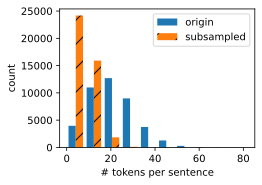

In [10]:
d2l.show_list_len_pair_hist(
    ['origin', 'subsampled'], '# tokens per sentence',
    'count', sentences, subsampled);

In [11]:
def compare_counts(token):
    return (f'"{token}"的数量：'
            f'之前={sum([l.count(token) for l in sentences])}, '
            f'之后={sum([l.count(token) for l in subsampled])}')

compare_counts('the')

'"the"的数量：之前=50770, 之后=1953'

In [12]:
compare_counts('join')

'"join"的数量：之前=45, 之后=45'

相比之下低频词会较好的保留

In [13]:
vocab['the']

1

单词序列转成索引序列

In [14]:
corpus = [vocab[line] for line in subsampled]
corpus[:3]

[[], [71, 392, 2115, 145, 406], [5277, 3054, 1580]]

In [15]:
def get_centers_and_contexts(corpus, max_window_size):
    """返回跳元模型中的中心词和上下文词"""
    centers, contexts = [], []
    for line in corpus:
        # 要形成“中心词-上下文词”对，每个句子至少需要有2个词
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # 上下文窗口中间i
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            # 从上下文词中排除中心词
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

创建一个包含两个句子的小数据集，测试一下

In [16]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('数据集', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('中心词', center, '的上下文词是', context)

数据集 [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
中心词 0 的上下文词是 [1, 2]
中心词 1 的上下文词是 [0, 2]
中心词 2 的上下文词是 [0, 1, 3, 4]
中心词 3 的上下文词是 [1, 2, 4, 5]
中心词 4 的上下文词是 [2, 3, 5, 6]
中心词 5 的上下文词是 [3, 4, 6]
中心词 6 的上下文词是 [4, 5]
中心词 7 的上下文词是 [8, 9]
中心词 8 的上下文词是 [7, 9]
中心词 9 的上下文词是 [7, 8]


In [17]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# “中心词-上下文词对”的数量: {sum([len(contexts) for contexts in all_contexts])}'

'# “中心词-上下文词对”的数量: 1502133'

In [18]:
len(all_centers) # 中心词有342611

342898

### 负采样

使用负采样进行近似训练

In [19]:
class RandomGenerator:
    """根据n个采样权重在{1,...,n}中随机抽取"""
    def __init__(self, sampling_weights):
        # Exclude
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            # 缓存k个随机采样结果
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]

In [20]:
generator = RandomGenerator([2, 3, 4])
[generator.draw() for _ in range(10)]

[3, 2, 3, 3, 3, 3, 2, 3, 3, 2]

对于一对中心词和上下文词，我们随机抽取了K个（实验中为5个）噪声词，产生负样本列表

为什么采用负采样？

1）将多分类问题转换成K+1个二分类问题，从而减少计算量，加快训练速度。

2）保证模型训练效果，因为目标词只跟相近的词有关，没有必要使用全部的单词作为负例来更新它们的权重。

In [21]:
def get_negatives(all_contexts, vocab, counter, K):
    """返回负采样中的噪声词"""
    # 索引为1、2、...（索引0是词表中排除的未知标记）
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75
                        for i in range(1, len(vocab))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # 噪声词不能是上下文词
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

all_negatives = get_negatives(all_contexts, vocab, counter, 5)

### 小批量加载训练

在提取了所有的中心词和上下文词对并进行负采样之后，将他们转换成小批量样本，在训练过程中可以迭代加载。
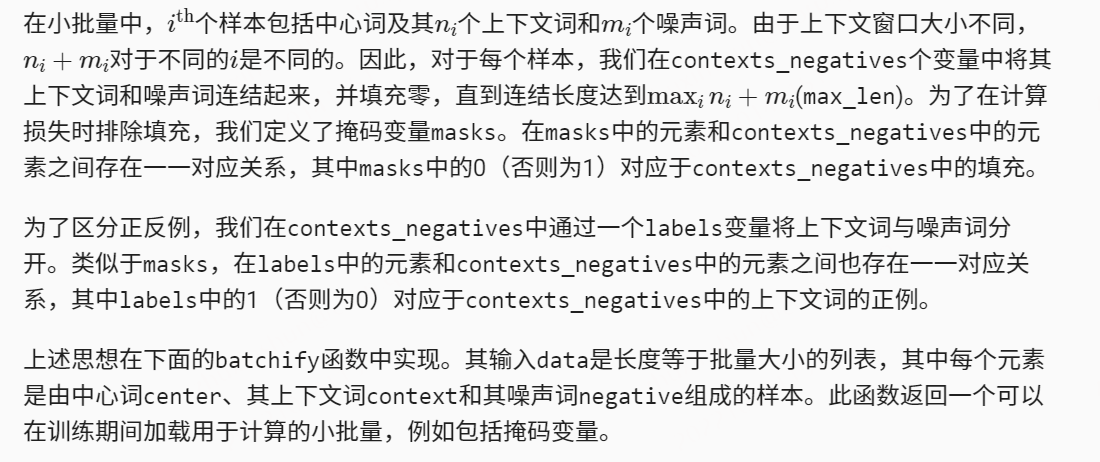


In [22]:
def batchify(data):
    """返回带有负采样的跳元模型的小批量样本"""
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += \
            [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
        contexts_negatives), torch.tensor(masks), torch.tensor(labels))

In [23]:
x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


代码整合

In [24]:
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    """下载PTB数据集，然后将其加载到内存中"""
    num_workers = d2l.get_dataloader_workers()
    sentences = read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negatives(
        all_contexts, vocab, counter, num_noise_words)

    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives

        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index],
                    self.negatives[index])

        def __len__(self):
            return len(self.centers)

    dataset = PTBDataset(all_centers, all_contexts, all_negatives)
    
    data_iter = torch.utils.data.DataLoader(
        dataset, batch_size, shuffle=True,
        collate_fn=batchify, num_workers=num_workers)
    return data_iter, vocab

dataset 的格式 一个中心词 + 上下文词 + 负采样列表

In [25]:
# class PTBDataset(torch.utils.data.Dataset):
#         def __init__(self, centers, contexts, negatives):
#             assert len(centers) == len(contexts) == len(negatives)
#             self.centers = centers
#             self.contexts = contexts
#             self.negatives = negatives

#         def __getitem__(self, index):
#             return (self.centers[index], self.contexts[index],
#                     self.negatives[index])

#         def __len__(self):
#             return len(selfa.centers)

# dataset = PTBDataset(all_centers, all_contexts, all_negatives)
# dataset[0]

In [26]:
data_iter, vocab = load_data_ptb(512, 5, 5)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])


### 跳元模型

#### 嵌入层

***嵌入层将词元的索引映射到其特征向量。该层的权重是一个矩阵，其行数等于字典大小（input_dim），列数等于每个标记的向量维数（output_dim）。在词嵌入模型训练之后，这个权重就是我们所需要的。***


In [27]:
from torch import nn

In [68]:
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
print(f'Parameter embedding_weight ({embed.weight.shape}, '
      f'dtype={embed.weight.dtype})')

Parameter embedding_weight (torch.Size([20, 4]), dtype=torch.float32)


嵌入层的输入是词元（词）的索引。对于任何词元索引，其向量表示可以从嵌入层中的权重矩阵的第i行获得。由于向量维度（output_dim）被设置为4，因此当小批量词元索引的形状为（2，3）时，嵌入层返回具有形状（2，3，4）的向量。

    tensor 中的值不能超过num_embeddings-1  参考 https://www.jb51.net/article/254032.htm

In [70]:
x = torch.tensor([[1, 19, 3], [4, 5, 6]])
embed(x)

tensor([[[ 0.6528,  0.0818, -0.7172,  0.1859],
         [-1.9744,  2.1484, -0.1178, -0.1054],
         [-0.3386, -0.1532, -1.3729,  0.7055]],

        [[ 0.0864,  0.9157, -0.4542,  0.2409],
         [-1.1129,  0.2038, -1.9004, -0.9774],
         [-0.3400,  0.8305, -0.8315,  0.1698]]], grad_fn=<EmbeddingBackward0>)

定义前向传播

在前向传播中，跳元语法模型的输入包括形状为（批量大小，1）的中心词索引center和形状为（批量大小，max_len）的上下文与噪声词索引contexts_and_negatives，其中max_len已定义。这两个变量首先通过嵌入层从词元索引转换成向量，然后它们的批量矩阵相乘返回形状为（批量大小，1，max_len）的输出。输出中的每个元素是中心词向量和上下文或噪声词向量的点积。

In [30]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

torch.bmm 用于两个三维矩阵相乘,permute 转换矩阵维度确保可以相乘

In [31]:
skip_gram(torch.ones((2, 1), dtype=torch.long),
          torch.ones((2, 4), dtype=torch.long), embed, embed).shape

torch.Size([2, 1, 4])

### 训练 

训练之前先定义损失函数

二元交叉熵损失

In [32]:
class SigmoidBCELoss(nn.Module):
    # 带掩码的二元交叉熵损失
    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)

loss = SigmoidBCELoss()

给定变量

In [33]:
pred = torch.tensor([[1.1, -2.2, 3.3, -4.4]] * 2)
label = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])


In [34]:
loss(pred, label, mask)

tensor([0.9352, 0.9231])

In [35]:
loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1)

tensor([0.9352, 1.8462])

初始化模型参数

In [36]:
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size))

In [37]:
net

Sequential(
  (0): Embedding(6719, 100)
  (1): Embedding(6719, 100)
)

In [38]:
net[0]

Embedding(6719, 100)

定义训练阶段代码

In [46]:
def train(net, data_iter, lr, num_epochs):
    def init_weights(m):
        if type(m) == nn.Embedding:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    # 规范化的损失之和，规范化的损失数
    metric = d2l.Accumulator(2)
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [data for data in batch]

            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask)
                     / mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on cpu')

loss 0.410, 132694.0 tokens/sec on cpu


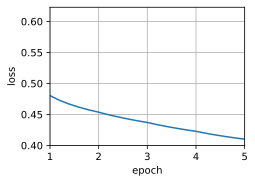

In [47]:
lr, num_epochs = 0.002, 5
train(net, data_iter, lr, num_epochs)

In [57]:
W = net[0].weight.data

In [58]:
W[0]

tensor([-0.0117, -0.0192, -0.0054,  0.0148,  0.0291, -0.0262,  0.0021, -0.0101,
        -0.0039, -0.0238,  0.0042,  0.0030, -0.0019, -0.0200, -0.0100, -0.0086,
         0.0226, -0.0215, -0.0167, -0.0073,  0.0043,  0.0191, -0.0170, -0.0031,
         0.0235,  0.0183,  0.0183,  0.0164, -0.0224,  0.0043,  0.0066,  0.0158,
        -0.0240,  0.0140,  0.0262,  0.0016, -0.0296, -0.0215,  0.0109, -0.0251,
        -0.0067,  0.0230, -0.0252,  0.0287,  0.0221,  0.0174,  0.0087,  0.0064,
         0.0275, -0.0017,  0.0021,  0.0021,  0.0243, -0.0059,  0.0200,  0.0272,
         0.0016,  0.0216,  0.0058,  0.0171,  0.0091, -0.0102,  0.0206, -0.0159,
        -0.0162,  0.0031, -0.0166,  0.0092, -0.0133, -0.0249, -0.0271, -0.0093,
         0.0136,  0.0272,  0.0233, -0.0236,  0.0153,  0.0027,  0.0035,  0.0284,
        -0.0022, -0.0254, -0.0099,  0.0204,  0.0254,  0.0014,  0.0070, -0.0216,
        -0.0195, -0.0172, -0.0032, -0.0014, -0.0226, -0.0036,  0.0188,  0.0052,
        -0.0204, -0.0051, -0.0266,  0.01

In [56]:
net[1].weight.data

tensor([[-2.7394e-02,  2.3535e-02,  3.7020e-05,  ..., -2.1715e-02,
         -2.7019e-02, -1.8479e-02],
        [ 3.0778e-01, -5.7306e-01, -3.8280e-01,  ..., -4.5218e-01,
          1.2810e-01, -4.8812e-01],
        [ 2.8436e-01, -5.2894e-02, -4.9744e-01,  ..., -2.0400e-01,
         -2.3849e-01, -1.9559e-01],
        ...,
        [ 2.2001e-01, -4.1073e-01, -1.1359e-01,  ..., -4.5519e-02,
          2.0684e-01, -2.4719e-02],
        [ 2.6016e-01,  8.5061e-02, -1.4852e-01,  ..., -4.9444e-02,
          6.8369e-01, -1.4369e-01],
        [-1.3151e-02, -3.0883e-01, -3.6212e-01,  ..., -4.6453e-01,
          8.3679e-01, -1.0338e-01]])

测试效果

In [59]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    # 计算余弦相似性。增加1e-9以获得数值稳定性
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
                                      torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:  # 删除输入词
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

In [65]:
get_similar_tokens('microprocessor', 3, net[0])

cosine sim=0.736: intel
cosine sim=0.711: chip
cosine sim=0.703: desktop
